<a href="https://colab.research.google.com/github/ShanMehsood/visual_attention/blob/main/tf_2_visual_attention_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0  Visual Attention

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install utils

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import logistic
# from utils.visualize import plotImages, plotHistory, explainGradCam

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
def plotImages(images_batch, img_n, classes):
    """
    Take as input a batch from the generator and plt a number of images equal to img_n
    Default columns equal to max_c. At least inputs of batch equal two
    """
    max_c = 5

    if img_n <= max_c:
        r = 1
        c = img_n
    else:
        r = math.ceil(img_n/max_c)
        c = max_c

    fig, axes = plt.subplots(r, c, figsize=(15, 15))
    axes = axes.flatten()
    for img_batch, label_batch, ax in zip(images_batch[0], images_batch[1], axes):
        ax.imshow(img_batch)
        ax.grid()
        ax.set_title('Class: {}'.format(classes[label_batch]))
    plt.tight_layout()
    plt.show()


In [ ]:
def plotHistory(history, set_y_min=0, set_y_max=1.5):
    """
    Plot the loss and accuracy curves for training and validation
    """
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(set_y_min, set_y_max)
    plt.show()

In [ ]:
def explainGradCam(explainer, ax, img, y, model_1, y_pred_1, model_2, y_pred_2, class_names):
    """
    [Attention Episode]
    Plot GRADCAM of two trained models. It needs an axes with two columns
    """
    data = ([img], None)

    y_predm_1 = np.argmax(y_pred_1)
    y_predm_2 = np.argmax(y_pred_2)

    grid_1 = explainer.explain(
        data, model_1, class_index=y_predm_1, image_weight=0.8)
    grid_2 = explainer.explain(
        data, model_2, class_index=y_predm_2, image_weight=0.8)

    ax[0].set_xlabel("Pred: {} {:2.0f}% ({})".format(class_names[y_predm_1],
                                                     100*np.max(y_pred_1),
                                                     class_names[y]),
                     color=('blue' if y == y_predm_1 else 'red'))

    ax[1].set_xlabel("Pred: {} {:2.0f}% ({})".format(class_names[y_predm_2],
                                                     100*np.max(y_pred_2),
                                                     class_names[y]),
                     color=('blue' if y == y_predm_2 else 'red'))
    ax[0].imshow(grid_1)
    ax[1].imshow(grid_2)


## 2.1 CBAM: Convolutional Block Attention Module
<a>https://arxiv.org/abs/1807.06521</a>

In [ ]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [ ]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

# 3.0 Build a Model

## 3.1 Download a dataset (CIFAR 10)

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

### 3.1.1 Visualize the dataset

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learni

In [ ]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

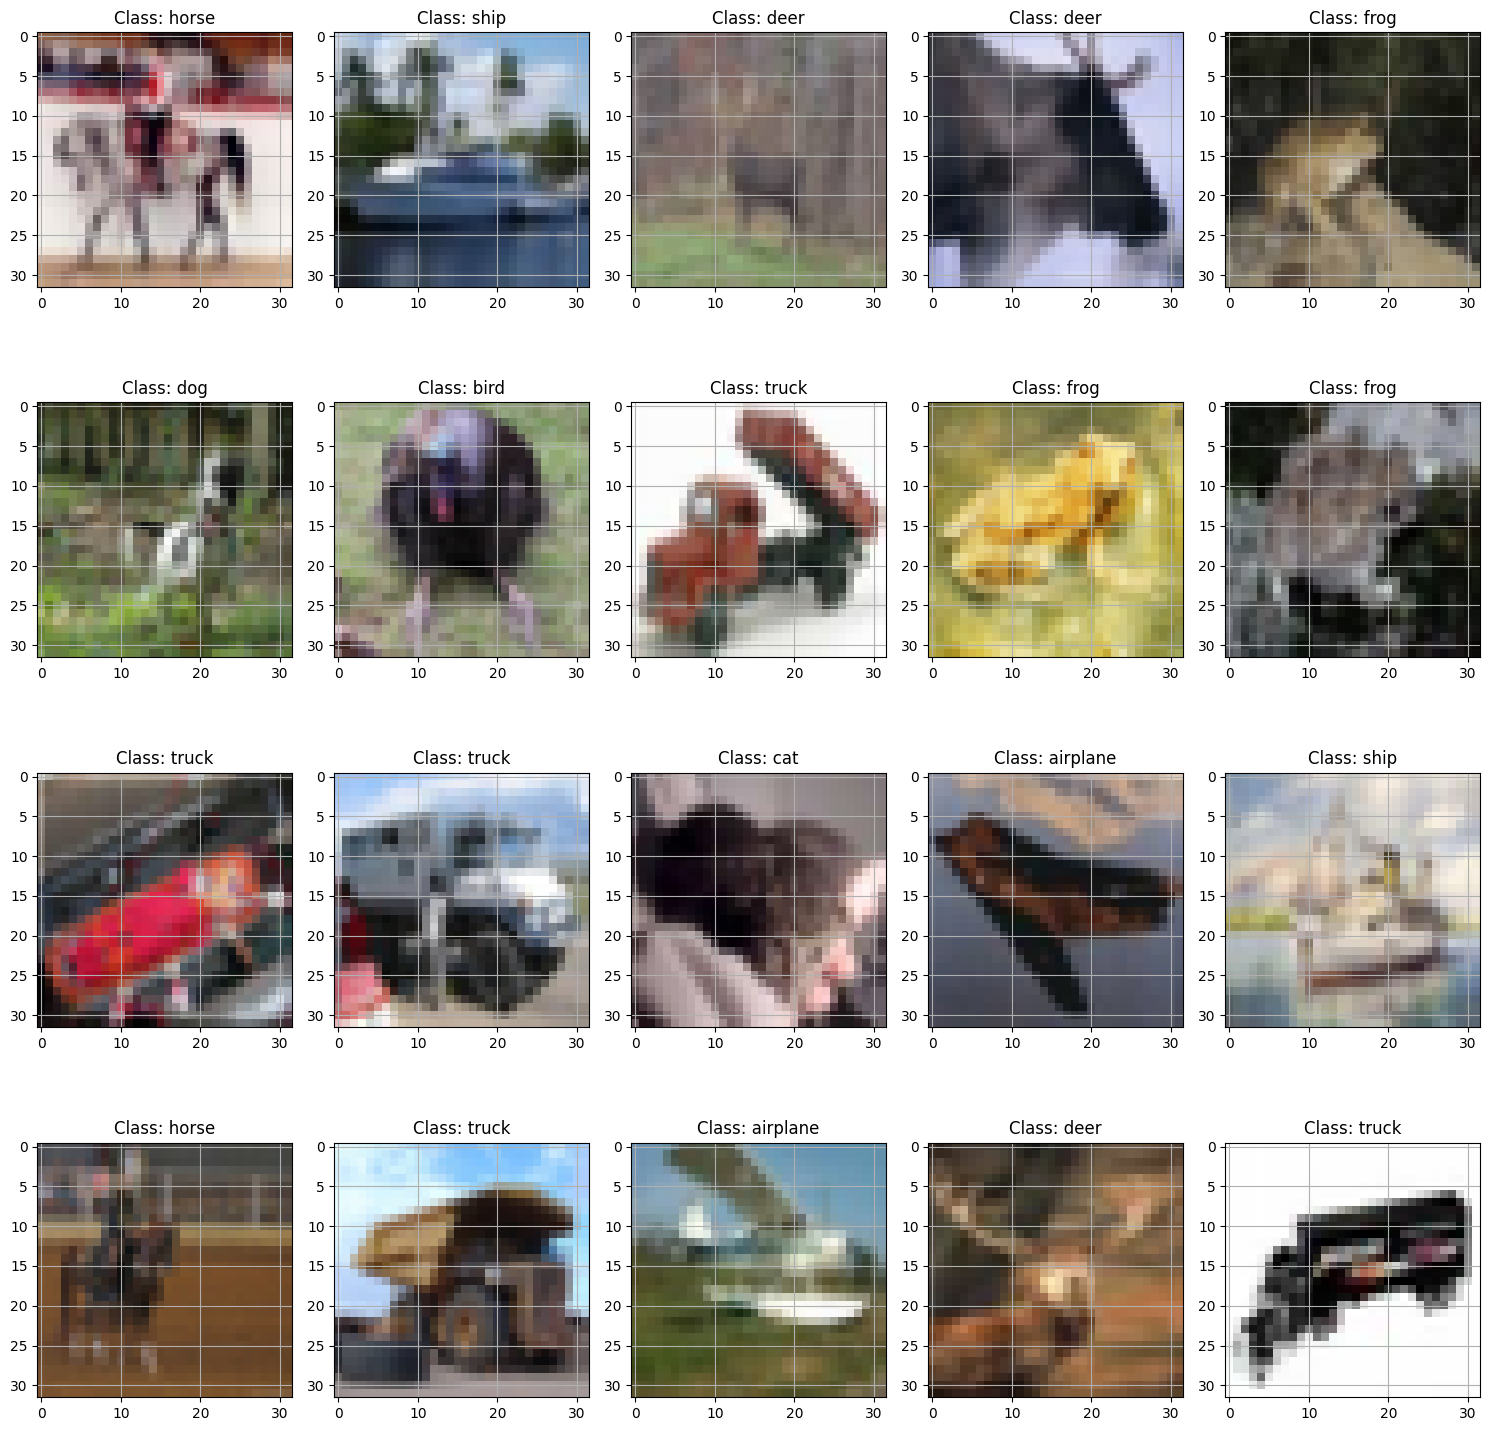

In [ ]:
for data in ds_train.batch(20):
    plotImages(data, 20, ds_info.features['label'].names)
    break

### 3.1.2 Build a dataset pipeline

In [ ]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## 3.2 Build a network without attention

In [ ]:
simple_cnn_no_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
])

In [ ]:
simple_cnn_no_attention.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_9 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_10 (Ba  (None, 16, 16, 64)       

In [ ]:
simple_cnn_no_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [ ]:
history = simple_cnn_no_attention.fit(ds_train, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 19s 7ms/step - loss: 1.1688 - accuracy: 0.5835
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7634 - accuracy: 0.7353
Epoch 3/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6098 - accuracy: 0.7896
Epoch 4/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5065 - accuracy: 0.8242
Epoch 5/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.4274 - accuracy: 0.8509
Epoch 6/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.3578 - accuracy: 0.8754
Epoch 7/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2976 - accuracy: 0.8957
Epoch 8/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.2444 - accuracy: 0.9132
Epoch 9/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2085 - accuracy: 0.9266
Epoch 10/20
1563/1563 [==============================] - 10s 7ms/step - l

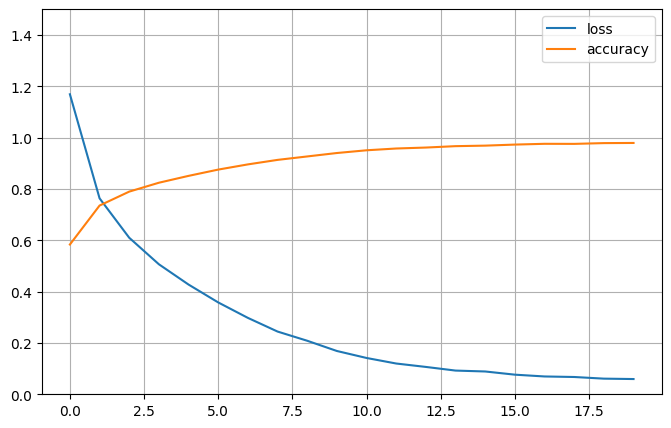

In [ ]:
plotHistory(history)

In [ ]:
print(f"Test accuracy: {simple_cnn_no_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 2s 7ms/step - loss: 0.9486 - accuracy: 0.8082
Test accuracy: 0.8082000017166138


## 3.3 Builid a network with attention

In [ ]:
simple_cnn_with_attention = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax' )
])

In [ ]:
simple_cnn_with_attention.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_13 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_14 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 channel_attention_3 (Chann  (None, 32, 32, 32)        0         
 elAttention)                                                    
                                                      

In [ ]:
simple_cnn_with_attention.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [ ]:
history = simple_cnn_with_attention.fit(ds_train, epochs=20)

Epoch 1/20
1563/1563 [==============================] - 14s 7ms/step - loss: 1.1798 - accuracy: 0.5773
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7663 - accuracy: 0.7332
Epoch 3/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6143 - accuracy: 0.7857
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5087 - accuracy: 0.8245
Epoch 5/20
1563/1563 [==============================] - 10s 7ms/step - loss: 0.4270 - accuracy: 0.8517
Epoch 6/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3595 - accuracy: 0.8748
Epoch 7/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2989 - accuracy: 0.8957
Epoch 8/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2494 - accuracy: 0.9130
Epoch 9/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.2068 - accuracy: 0.9265
Epoch 10/20
1563/1563 [==============================] - 10s 7ms/step - l

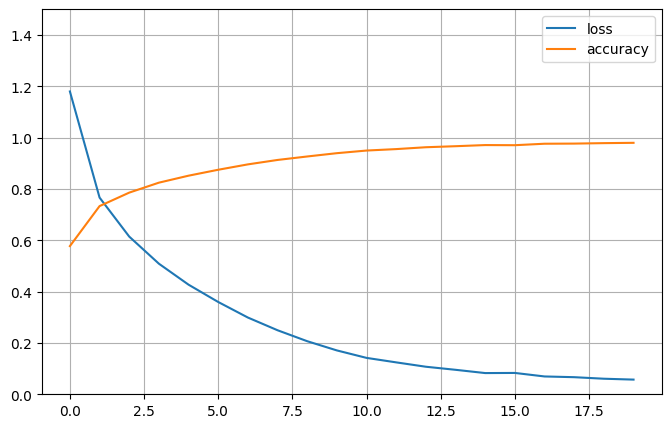

In [ ]:
plotHistory(history)

In [ ]:
print(f"Test accuracy: {simple_cnn_with_attention.evaluate(ds_test)[1]}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8868 - accuracy: 0.8183
Test accuracy: 0.8183000087738037


# 4.0 Visualize Network Attention

In [ ]:
!pip install tf-explain
from tf_explain.core.grad_cam import GradCAM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 949.3 kB/s eta 0:00:00


In [ ]:
explainer = GradCAM()

In [ ]:
for images, labels in tfds.as_numpy(ds_test.take(1)):
    X_test = images
    y_test = labels

In [ ]:
print(X_test.shape, y_test.shape)

(32, 32, 32, 3) (32,)


## 4.1 Network without vs with attention

1/1 [==============================] - 0s 16ms/step


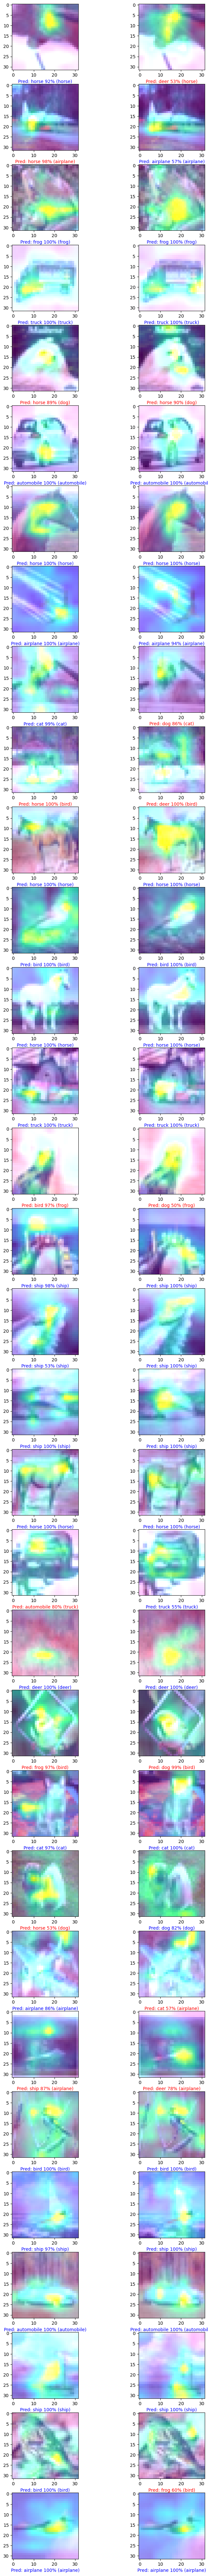

In [ ]:
fig, axes = plt.subplots(32, 2, figsize=(8,80))
fig.tight_layout()
index = 0
for img, label in zip(X_test, y_test):
    explainGradCam(explainer, axes[index], img,
               label,
               simple_cnn_no_attention,
               simple_cnn_no_attention.predict(img[None]),
               simple_cnn_with_attention,
               simple_cnn_with_attention.predict(img[None]),
               class_names=ds_info.features['label'].names)
    index += 1